# Tasks (Read prediction)

Since we don’t have access to the test labels, we’ll need to simulate validation/test sets of our own. So, let’s split the training data (‘train Interactions.csv.gz’) as follows:

(1) Reviews 1-190,000 for training

(2) Reviews 190,001-200,000 for validation

(3) Upload to Kaggle for testing only when you have a good model on the validation set. This will save you time (since Kaggle can take several minutes to return results), and prevent you from exceeding your daily submission limit.

In [24]:
# ============ Environment Setup ============
# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# import some packages
import gzip
import random
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict

def splitDataset(datapath):
    """
    Split the training data (‘train Interactions.csv.gz’) as follows:
    (1) Reviews 1-190,000 for training
    (2) Reviews 190,001-200,000 for validation
    :param datapath:
    :return: train, valid as dataframe
    """
    f = gzip.open(datapath, 'rt')
    data = pd.read_csv(f)
    train, valid = data[:190001], data[190001:]
    return data, train, valid

data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

## Question 1

Although we have built a validation set, it only consists of positive samples. For this task we also need examples of user/item pairs that weren’t read. For each entry (user,book) in the validation set, sample a negative entry by randomly choosing a book that user hasn’t read. Evaluate the performance (accuracy) of the baseline model on the validation set you have built (1 mark).

In [57]:
def sampleNegative(data, train, valid):
    """
    For each entry (user,book) in the validation set, sample a negative entry
        by randomly choosing a book that user hasn’t read.
    :param train:
    :param valid:
    :return:
    """
    valid['read'] = 1
    NegValid = valid

    userBookDict = {}
    print("Preprocessing Data userBookDict ...")
    for index, row in tqdm(data.iterrows()):
        if row['userID'] not in userBookDict:
            userBookDict[row['userID']] = {row['bookID']}
        else:
            userBookDict[row['userID']].add(row['bookID'])

    for index, row in tqdm(valid.iterrows()):
        samNegBookID = random.sample(set(data['bookID']) - userBookDict[row['userID']], 1)[0]
        NegValid = NegValid.append({'userID': row['userID'], 'bookID': samNegBookID, 'rating': 0, 'read':0}, ignore_index=True)

    return NegValid, userBookDict 

In [50]:
def baselineOnValidation():
    random.seed(5583)
    data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
    print("Sampling Negative samples ...")
    valid, _ = sampleNegative(data, train, valid)

    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in tqdm(train.iterrows()):
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalRead / 2:
            break

    print('Evaluating ...')
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        if row['bookID'] in return1:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    print('Accuracy on Validation set is %.3f' % (correct/len(valid)))

baselineOnValidation()

Sampling Negative samples ...
Preprocessing Data userBookDict ...



Training ...



Evaluating ...



Accuracy on Validation set is 0.644


## Question 2

The existing ‘read prediction’ baseline just returns True if the item in question is ‘popular,’ using a threshold of the 50th percentile of popularity (totalRead/2). Assuming that the ‘non-read’ test examples are a random sample of user-book pairs, this threshold may not be the best one. See if you can find a better threshold and report its performance on your validatin set (1 mark).

Sampling Negative samples ...
Preprocessing Data userBookDict ...



Training ...
Evaluating on threshold 1 ...
Evaluating on threshold 2 ...
Evaluating on threshold 3 ...
Evaluating on threshold 4 ...
Evaluating on threshold 5 ...
Evaluating on threshold 6 ...
Evaluating on threshold 7 ...
Evaluating on threshold 8 ...
Evaluating on threshold 9 ...
Evaluating on threshold 10 ...


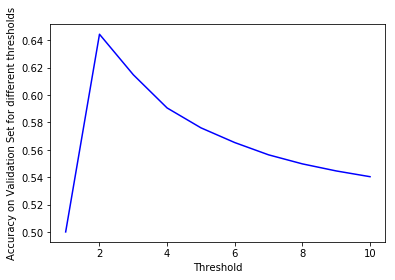

In [51]:
import matplotlib.pyplot as plt

def baselineOnValidation():
    random.seed(5583)
    data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
    print("Sampling Negative samples ...")
    valid, _ = sampleNegative(data, train, valid)
    
    acc = []
    thresholds = list(range(1, 11))
    
    bookCount = defaultdict(int)
    totalRead = 0

    print('Training ...')
    for index, row in train.iterrows():
        bookCount[row['bookID']] += 1
        totalRead += 1

    mostPopular = [(bookCount[x], x) for x in bookCount]
    mostPopular.sort()
    mostPopular.reverse()

    for threshold in thresholds:
        return1 = set()
        count = 0
        for ic, i in mostPopular:
            count += ic
            return1.add(i)
            if count > totalRead / threshold:
                break

        print('Evaluating on threshold %d ...' % threshold)
        correct = 0
        for index, row in valid.iterrows():
            if row['bookID'] in return1:
                correct += (row['read'] != 0)
            else:
                correct += (row['read'] == 0)

        acc.append(correct/len(valid))

    plt.plot(thresholds, acc, 'b-')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy on Validation Set for different thresholds')
    plt.show()
    
baselineOnValidation()

As we can see, the best accuracy on validation set was achieved at threshold around $1.9$. And the accuracy is around $0.647$.

## Question 3

A stronger baseline than the one provided might make use of the Jaccard similarity (or another similarity metric). Given a pair (u, b) in the validation set, consider all training items b′ that user u has read. For each, compute the Jaccard similarity between b and b', i.e., users (in the training set) who have read b and users who have read b'. Predict as ‘read’ if the maximum of these Jaccard similarities exceeds a threshold (you may choose the threshold that works best). Report the performance on your validation set (1 mark).

In [62]:
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

Sampling Negative samples ...
Preprocessing Data userBookDict ...


Evaluating on threshold 0.500 ...



Evaluating on threshold 0.250 ...



Evaluating on threshold 0.125 ...



Evaluating on threshold 0.062 ...



Evaluating on threshold 0.031 ...



Evaluating on threshold 0.016 ...



Evaluating on threshold 0.008 ...



Evaluating on threshold 0.004 ...



Evaluating on threshold 0.002 ...


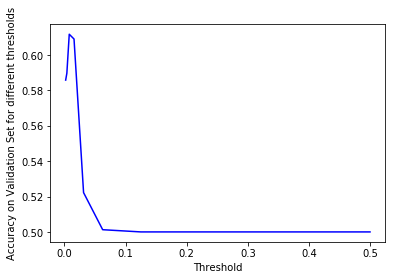

In [75]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

thresholds = [1/2**i for i in range(1, 10)]
acc = []
for threshold in thresholds:
    print('Evaluating on threshold %.3f ...' % threshold)
    correct = 0
    for index, row in tqdm(valid.iterrows()):
        userReads = userReadBook[row['userID']]
        jac = []
        for book in userReads:
            if row['bookID'] not in BookwasRead:
                jac.append(0)
            else:
                jac.append(Jaccard(BookwasRead[row['bookID']], BookwasRead[book]))
                
        if max(jac) > threshold:
            correct += (row['read'] != 0)
        else:
            correct += (row['read'] == 0)
    
    acc.append(correct/len(valid))

plt.plot(thresholds, acc, 'b-')
plt.xlabel('Threshold')
plt.ylabel('Accuracy on Validation Set for different thresholds')
plt.show()

In [76]:
print('threshold %.3f, accuracy %.3f' % (thresholds[acc.index(max(acc))], max(acc)))

threshold 0.008, accuracy 0.612


## Question 4

Improve the above predictor by incorporating both a Jaccard-based threshold and a popularity based threshold. Report the performance on your validation set (1 mark).

In [77]:
# preprocessing
random.seed(5583)
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")
print("Sampling Negative samples ...")
valid, _ = sampleNegative(data, train, valid)

userReadBook, BookwasRead = {}, {}
for index, row in tqdm(train.iterrows()):
    if row['userID'] not in userReadBook:
        userReadBook[row['userID']] = {row['bookID']}
    else:
        userReadBook[row['userID']].add(row['bookID'])
    if row['bookID'] not in BookwasRead:
        BookwasRead[row['bookID']] = {row['userID']}
    else:
        BookwasRead[row['bookID']].add(row['userID'])

Sampling Negative samples ...
Preprocessing Data userBookDict ...


In [78]:
bookCount = defaultdict(int)
totalRead = 0

print('Training ...')
for index, row in train.iterrows():
    bookCount[row['bookID']] += 1
    totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRead / 1.9:
        break

Training ...


In [84]:
print('Evaluating ...')
threshold_jac = 0.008
correct = 0
for index, row in tqdm(valid.iterrows()):
    userReads = userReadBook[row['userID']]
    jac = []
    for book in userReads:
        if row['bookID'] not in BookwasRead:
            jac.append(0)
        else:
            jac.append(Jaccard(BookwasRead[row['bookID']], BookwasRead[book]))

    if max(jac) > threshold_jac and row['bookID'] in return1:
        correct += (row['read'] != 0)
    else:
        correct += (row['read'] == 0)

print('Accuracy is %.3f' % (correct/len(valid)))

Evaluating ...



Accuracy is 0.650


## Question 5

To run our model on the test set, we’ll have to use the files ‘pairs Read.txt’ to find the reviewerID/itemID pairs about which we have to make predictions. Using that data, run the above model and upload your solution to Kaggle. Tell us your Kaggle user name (1 mark). If you’ve already uploaded a better solution to Kaggle, that’s fine too!

In [83]:
predictions = open("predictions_Read.txt", 'w')
for l in open("./data/pairs_Read.txt"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split('-')
    threshold_jac = 0.008
    userReads = userReadBook[u]
    jac = []
    for book in userReads:
        if b not in BookwasRead:
            jac.append(0)
        else:
            jac.append(Jaccard(BookwasRead[b], BookwasRead[book]))

    if max(jac) > threshold_jac and b in return1:
        predictions.write(u + '-' + b + ",1\n")
    else:
        predictions.write(u + '-' + b + ",0\n")

predictions.close()

### Kaggle

User name: shihanran

Display name: Shihan Ran

Email: sran@ucsd.edu

Public Leaderboard Score: 0.66016

# Tasks (Rating prediction)

Let’s start by building our training/validation sets much as we did for the first task. This time building a validation set is more straightforward: you can simply use part of the data for validation, and do not need to randomly sample non-read users/books.

## Question 9

Fit a predictor of the form

$$\text { rating (user, item ) } \simeq \alpha+\beta_{\text {user }}+\beta_{\text {item }}$$

by fitting the mean and the two bias terms as described in the lecture notes. Use a regularization parameter of $\lambda = 1$. Report the MSE on the validation set (1 mark).

In [101]:
import scipy
import scipy.optimize
import numpy as np

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userID'], d['bookID']) for index, d in train.iterrows()]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for index, d in train.iterrows():
        u,i = d['userID'], d['bookID']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return np.array(dtheta)

In [104]:
data, train, valid = splitDataset("./data/train_Interactions.csv.gz")

ratingMean = train['rating'].mean()
alpha = ratingMean

labels = train['rating']

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

users = list(set(train['userID']))
items = list(set(train['bookID']))
nUsers = len(users)
nItems = len(items)

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, 1))

MSE = 1.4735439815452338
MSE = 1.4560896560389294
MSE = 1.4733864367918064
MSE = 1.473386434421149


(array([ 3.89708841e+00, -1.09181866e-05,  4.64342014e-05, ...,
         5.75596559e-05, -4.36496224e-05, -8.75055609e-06]),
 1.473465196550704,
 {'grad': array([-2.47029336e-08, -2.86239826e-09, -1.43371249e-09, ...,
         -1.29515380e-08, -1.14558474e-08, -3.99377154e-09]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 4,
  'nit': 2,
  'warnflag': 0})

In [105]:
predictions = []
for index, d in valid.iterrows():
    u, i = d['userID'], d['bookID']
    predictions.append(prediction(u, i))
    
MSE(predictions, valid['rating'])

KeyError: 'b21479253'

## Question 10

Report the user and book IDs that have the largest and smallest values of $\beta$ (1 mark).

## Question 11

Find a better value of λ using your validation set. Report the value you chose, its MSE, and upload your solution to Kaggle by running it on the test data (1 mark).